This example is the simplest form of using an RBF kernel in an `ExactGP` module for regression. This basic model is usable when there is not much training data and no advanced techniques are required.

In this example, we’re modeling y = sin(2*pi*x)

Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
model = ExactGPModel(train_x.data, train_y.data, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.236   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/50 - Loss: 1.191   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/50 - Loss: 1.204   log_lengthscale: -0.190   log_noise: -0.200
Iter 4/50 - Loss: 1.106   log_lengthscale: -0.232   log_noise: -0.299
Iter 5/50 - Loss: 1.146   log_lengthscale: -0.299   log_noise: -0.399
Iter 6/50 - Loss: 1.060   log_lengthscale: -0.373   log_noise: -0.498
Iter 7/50 - Loss: 1.058   log_lengthscale: -0.452   log_noise: -0.597
Iter 8/50 - Loss: 1.029   log_lengthscale: -0.538   log_noise: -0.696
Iter 9/50 - Loss: 0.949   log_lengthscale: -0.628   log_noise: -0.793
Iter 10/50 - Loss: 0.895   log_lengthscale: -0.722   log_noise: -0.891
Iter 11/50 - Loss: 0.924   log_lengthscale: -0.813   log_noise: -0.988
Iter 12/50 - Loss: 0.997   log_lengthscale: -0.907   log_noise: -1.084
Iter 13/50 - Loss: 0.834   log_lengthscale: -1.005   log_noise: -1.180
Iter 14/50 - Loss: 0.898   log_lengthscale: -1.095   log_noise: -1.276
Iter 15/50 - Loss

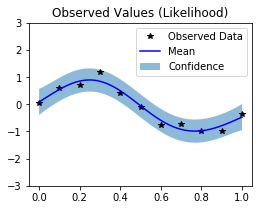

In [6]:
# Put model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

In [13]:
u = torch.nn.Parameter(torch.Tensor([0.2, 0.4]))
outcome_samples = model(u).sample(64)
expected_val = outcome_samples.mean(1).sum()
print(u.grad)
expected_val.backward()
print(u.grad)

None
tensor([ 1.6322, -4.7900])
